# Synthetic Data Generation Baseline

In [3]:
import os, sys
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
import pickle
import sklearn
import tqdm.notebook as tqdm

from sklearn.model_selection import train_test_split
sns.set_theme()
sys.path.append(os.path.abspath('..'))

torch.backends.cudnn.benchmark = True

In [4]:
%load_ext autoreload
%autoreload 2

from src.vae_models import CVAE
import src.datasets as datasets
import src.utils as utils
import src.preprocess as preprocess
import src.condition as condition

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import Data

In [5]:
DATASET_DIR = "../data"
DATASET_NAME = 'goi4_dp_full_Gipuzkoa'
dataset_path = os.path.join(DATASET_DIR, DATASET_NAME)

RANDOM_SEED = 2112
np.random.seed(RANDOM_SEED)

In [6]:
df = pd.read_csv(os.path.join(dataset_path, 'dataset.csv'))
data, dates, users = df.iloc[:,:-2].values, df.date.values, df.user.values
num_days, num_users = df.date.nunique(), df.user.nunique()
print(f'Dataset: {DATASET_NAME}')
print(f'Loaded {len(data)} consumption profiles from {num_days} dates and {num_users} users.')

Dataset: goi4_dp_full_Gipuzkoa
Loaded 2522880 consumption profiles from 365 dates and 6912 users.


In [7]:
date_dict = np.load(os.path.join(dataset_path, 'encode_dict.npy'), allow_pickle=True).item()["date_dict"]
date_dict_inv = {v: k for k, v in date_dict.items()}
if not os.path.exists(os.path.join(dataset_path, 'raw_dates.npy')):
    raw_dates = np.array([datetime.datetime.strptime(date_dict_inv[d], '%Y-%m-%d') for d in dates])
    np.save(os.path.join(dataset_path, 'raw_dates.npy'), raw_dates)
else: raw_dates = np.load(os.path.join(dataset_path, 'raw_dates.npy'), allow_pickle=True)

In [8]:
metadata = pd.read_csv(os.path.join(dataset_path, 'metadata.csv'))
unique_provinces = metadata.province.unique()
print(f'Loaded metadata for {len(unique_provinces)} provinces')
print(f"Uniqe provinces are: {unique_provinces}")

Loaded metadata for 1 provinces
Uniqe provinces are: ['Gipuzkoa']


#### Set the Resolution and Pad

In [9]:
RESOLUTION = 1 #in hours
PAD = 0
X = np.reshape(np.reshape(data, (num_users, num_days, -1)), (num_users, num_days, -1))

#### Clean the Dataset

In [10]:
X, user_mask = preprocess.remove_unwanted_profiles(X)

Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles


#### Subsample the Dataset

In [11]:
USER_SUBSAMPLE_RATE, DAY_SUBSAMPLE_RATE = 100, 1
X, raw_dates = preprocess.subsample_data(X, np.reshape(raw_dates, (num_users, num_days))[user_mask], USER_SUBSAMPLE_RATE, DAY_SUBSAMPLE_RATE)

In [12]:
num_users, num_days, num_features = X.shape

print("{:.<40}{:.>5}".format("Number of (subsampled/filtered) users", num_users))
print("{:.<40}{:.>5}".format("Number of (subsampled) days", num_days))
print("{:.<40}{:.>5}".format("Number of (aggregated) features", num_features))

Number of (subsampled/filtered) users......69
Number of (subsampled) days...............365
Number of (aggregated) features............24


#### Ampute the Dataset

In [13]:
X_missing, missing_idx, num_missing_profiles, missing_days = preprocess.ampute_data(X, a=0.85, b=10.0, random_seed=RANDOM_SEED)

Mean of enrolments: 28.59


#### Prepare the Training Data with Missing Records

In [15]:
SHIFT = 1.0
ZERO_ID = -3
LOG_SPACE = True
nonzero_mean, nonzero_std = utils.zero_preserved_log_stats(X_missing)
X_missing = utils.zero_preserved_log_normalize(X_missing, nonzero_mean, nonzero_std, log_output=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)

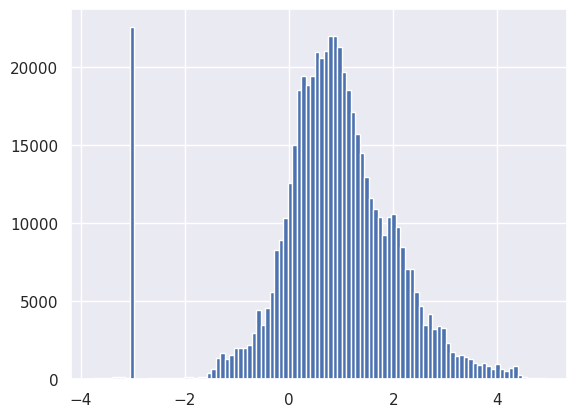

In [16]:
plt.hist(X_missing.flatten(), bins=100)
plt.show()

### Prepare Conditions

In [17]:
condition_tag_list = ["months", "weekdays", "users"]

NUM_TOPICS = 20
VOCAB_SIZE = 1000
ALPHA = 1.0/NUM_TOPICS

model_kwargs = {"num_topics": NUM_TOPICS,
                "reduce_dim": False,
                "num_lower_dims": None,
                "num_clusters": VOCAB_SIZE,
                "random_state": RANDOM_SEED,
                "user_subsample_rate": USER_SUBSAMPLE_RATE,}
fit_kwargs = {"lda": {'doc_topic_prior': ALPHA,  ## alpha
                    'topic_word_prior': 1.0/VOCAB_SIZE, ## eta
                    'perp_tol': 5e-2, 
                    'max_iter': 10, ## number of epochs
                    'batch_size': 64, 
                    'verbose': True, 
                    'learning_method': 'online', 
                    'evaluate_every': 10,
                    'n_jobs': -1},}

user_embedding_kwargs = {"model_kwargs": model_kwargs, "fit_kwargs": fit_kwargs}

In [19]:
condition_kwargs, condition_set = condition.prepare_conditions(condition_tag_list, raw_dates, data=X_missing.reshape(num_users, num_days, -1), dataset_path=dataset_path, user_embedding_kwargs=user_embedding_kwargs)

#### Separate the test set

In [360]:
user_ids = np.arange(X.shape[0]).repeat(num_days)

X_observed = X_missing[~missing_idx]
user_ids_observed = user_ids[~missing_idx]
condition_set_observed = {k: v[~missing_idx] for k, v in condition_set.items()}

X_test_flat = np.reshape(X, (-1, num_features))[missing_idx]
X_test_list = [X[user, :missing_days[user]]*1 for user in range(num_users)]
user_ids_test = user_ids[missing_idx]
condition_set_test = {k: v[missing_idx] for k, v in condition_set.items()}

#### Separate the validation set

In [361]:
VAL_RATIO = 0.1
random_idx = np.random.permutation(len(X_observed))
val_idx = random_idx[:int(len(X_missing)*VAL_RATIO)]
train_idx = random_idx[int(len(X_missing)*VAL_RATIO):]

X_train, X_val = X_observed[train_idx], X_observed[val_idx]
user_ids_train, user_ids_val = user_ids_observed[train_idx], user_ids_observed[val_idx]
conditions_train = {k: v[train_idx] for k, v in condition_set_observed.items()}
conditions_val = {k: v[val_idx] for k, v in condition_set_observed.items()}

In [362]:
conditioner = datasets.Conditioner(**condition_kwargs, condition_set=condition_set_observed)
trainset = datasets.ConditionedDataset(inputs=X_train, conditions=conditions_train, conditioner=conditioner)
valset = datasets.ConditionedDataset(inputs=X_val, conditions=conditions_val, conditioner=conditioner)
print(f"Number of Training Points: {len(trainset)}")
print(f"Number of Validation Points: {len(valset)}")

Number of Training Points: 20756
Number of Validation Points: 2518


### Model

In [363]:
distribution_dict = {"posterior": {"dist_type": "normal",
                                    "learn_sigma": True,
                                    "sigma_lim": 0.05,
                                    "total_max_std": 3.0, 
                                    "mu_upper_lim": 5.0, 
                                    "mu_lower_lim": -5.0,
                                    "num_neurons": 750,
                                    "num_hidden_layers": 6,
                                    "dropout": True,
                                    "dropout_rate": 0.20,
                                    "batch_normalization": True,
                                    "resnet": False},
                    "likelihood": {"dist_type": "dict-gauss",
                                    "vocab_size": 100,
                                    "learn_sigma": True,
                                    "sigma_lim": 1e-4,
                                    "marginal_var_lim": 0.05,
                                    "total_max_std": 3.0, 
                                    "mu_upper_lim": 5.0, 
                                    "mu_lower_lim": ZERO_ID,
                                    "num_neurons": 750,
                                    "num_hidden_layers": 6,
                                    "dropout": True,
                                    "dropout_rate": 0.20,
                                    "batch_normalization": True,
                                    "resnet": False}
                    }

In [364]:
model_kwargs = {"latent_dim": 24,
                "condencoding_dim": None,
                "distribution_dict": distribution_dict,
                }

In [365]:
model = CVAE(input_dim=num_features, conditioner=conditioner, **model_kwargs)
print("Number of encoder parameters:", model.encoder._num_parameters())
print("Number of decoder parameters:", model.decoder._num_parameters())

Number of encoder parameters: 5157048
Number of decoder parameters: 5214124


### Training

In [366]:
train_kwargs = {
                "lr": 1e-3,
                "beta": 1.0,
                "num_mc_samples": 16,
                "validation_mc_samples": 16,
                "weight_decay": 1e-5,
                "gradient_clipping": True,
                "gradient_clipping_kwargs": {"max_norm":10.0},
                "lr_scheduling": True,
                "lr_scheduling_kwargs": {"threshold":1e-1, "factor":1/2, "patience":3, "min_lr":5e-5},
                "earlystopping": True,
                "earlystopping_kwargs": {"patience":10, "delta":1e-1},
                "epochs": 1000,
                "verbose_freq": 500,
                "tensorboard": True,
                "batch_size": 1024,
                "validation_freq": 1000,
                "device": "cuda:1",
                "tqdm_func": tqdm.tqdm,
                }

In [367]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_kwargs["batch_size"], shuffle=True, drop_last=True, num_workers=1, pin_memory=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=8196, shuffle=False, drop_last=False, num_workers=1, pin_memory=True)

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_kwargs["batch_size"], shuffle=True, drop_last=True)
# valloader = torch.utils.data.DataLoader(valset, batch_size=train_kwargs["batch_size"]*8, shuffle=False, drop_last=False)

In [368]:
torch.cuda.empty_cache()
model.fit(trainloader=trainloader, valloader=valloader, **train_kwargs)

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iteration in Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model.to("cpu")
model.prior_params = {k: v.to("cpu") for k, v in model.prior_params.items()}
model.eval()

CVAE(
  (encoder): GaussianNN(
    (parameterizer): ParameterizerNN(
      (block_dict): ModuleDict(
        (input): NNBlock(
          (input_layer): Sequential(
            (0): Linear(in_features=48, out_features=750, bias=True)
            (1): ReLU()
            (2): BatchNorm1d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): Dropout(p=0.2, inplace=False)
          )
          (middle_layers): ModuleList(
            (0-5): 6 x Sequential(
              (0): Linear(in_features=750, out_features=750, bias=True)
              (1): ReLU()
              (2): BatchNorm1d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): Dropout(p=0.2, inplace=False)
            )
          )
          (output_layer): Sequential(
            (0): Linear(in_features=750, out_features=750, bias=True)
            (1): ReLU()
            (2): BatchNorm1d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [ ]:
save_path = os.path.join(".", model.log_dir)
model_name = f'trained_model'
model_path = os.path.join(save_path, model_name + '.pt')
torch.save(model.state_dict(), model_path)
print(f'Model saved at {model_path}')

Model saved at ./runs/Jul23_19-40-14_iepg-compute1.ewi.tudelft.nl/trained_model.pt


In [ ]:
conditioner_path = os.path.join(save_path, 'conditioner.pkl')
with open(conditioner_path, 'wb') as f: pickle.dump(conditioner, f)
print(f'Conditioner saved at {conditioner_path}')

Conditioner saved at ./runs/Jul23_19-40-14_iepg-compute1.ewi.tudelft.nl/conditioner.pkl


## Load the Trained Model (if needed)

In [ ]:
LOAD_MODEL = True

model_path = None
conditioner_path = None

## Load the latest model
if model_path is None or conditioner_path is None:
    paths = [os.path.join("runs",f) for f in os.listdir("runs")]
    latest_path = paths[np.argmax([os.path.getmtime(f) for f in paths])]
    print(f'Loading model from {latest_path}')
    
    model_path = os.path.join(latest_path, 'trained_model.pt')
    conditioner_path = os.path.join(latest_path, 'conditioner.pkl')

Loading model from runs/Jul23_19-40-14_iepg-compute1.ewi.tudelft.nl


In [ ]:
if LOAD_MODEL:
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to("cpu")
    model.prior_params = {k: v.to("cpu") for k, v in model.prior_params.items()}
    model.eval()

    with open(conditioner_path, 'rb') as f: conditioner = pickle.load(f)

    print(f'Model loaded from {model_path}')
    print(f'Conditioner loaded from {conditioner_path}')

Model loaded from runs/Jul23_19-40-14_iepg-compute1.ewi.tudelft.nl/trained_model.pt
Conditioner loaded from runs/Jul23_19-40-14_iepg-compute1.ewi.tudelft.nl/conditioner.pkl


## Inspection

### Sigma Dictionary

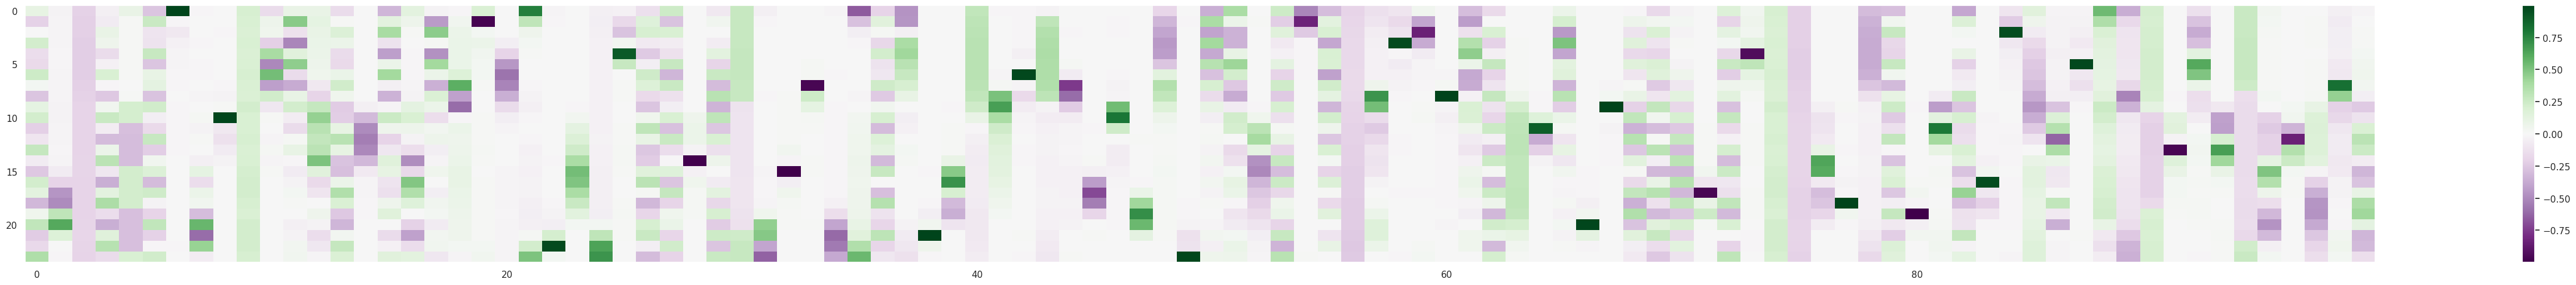

In [ ]:
fig, ax = plt.subplots(figsize=(50,5))
fig.tight_layout()
im = ax.imshow(model.decoder.get_SigmaMapper().detach().numpy(), aspect='auto', cmap='PRGn', interpolation='none')
ax.grid(False)
fig.colorbar(im, ax=ax)
plt.show()

### Validation Set

In [ ]:
x_val = torch.tensor(X_val).float()
x_val_conditions = conditions_val.copy()
x_rec, z_rec = model.reconstruct(x_val, torch.tensor(conditioner.transform(x_val_conditions)).float())

In [ ]:
x_rec_mu = x_rec["params"]["mu"].detach().squeeze(0)
x_rec_sigma = model.decoder.get_marginal_sigmas(x_rec["params"]).detach().squeeze(0)

x_val_Sigma = model.decoder.create_covariance_matrix(x_rec["params"]).squeeze(0).detach()
x_val_Corr = x_val_Sigma / (x_rec_sigma[...,None]*x_rec_sigma[:,None,:])

x_val_denorm = utils.zero_preserved_log_denormalize(x_val.unsqueeze(0), nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()
x_rec_denorm = utils.zero_preserved_log_denormalize(x_rec_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()
x_rec_denorm_sigma_low = utils.zero_preserved_log_denormalize(x_rec_mu - 2*x_rec_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()
x_rec_denorm_sigma_high = utils.zero_preserved_log_denormalize(x_rec_mu + 2*x_rec_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()

Reconstruction Log-Likelihood: -5.7477
KL Divergence: 2.2831
**************************************************
Top-5 Mimimum RLL: [-1360.8699   -222.20967  -150.8898   -130.21175  -124.82808] (Data index: [222750  43816 186297  86590  18949])
Top-5 Maximum KL: [21.219566 21.253456 21.300035 21.868565 23.103546] (Data index: [ 88655 106830  98838 143577 119308])


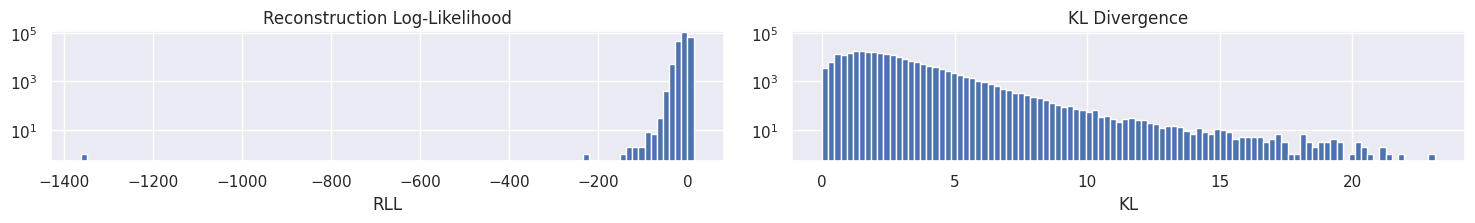

In [ ]:
rll_val = model.reconstruction_loglikelihood(x_val, x_rec["params"]).detach().numpy()
kl_val = model.kl_divergence(z_rec["params"], prior_params=model.prior_params).detach().numpy()

print(f"Reconstruction Log-Likelihood: {rll_val.mean():.4f}")
print(f"KL Divergence: {kl_val.mean():.4f}")
print("*"*50)
print(f"Top-5 Mimimum RLL: {np.sort(rll_val)[:5]} (Data index: {np.argsort(rll_val)[:5]})")
print(f"Top-5 Maximum KL: {np.sort(kl_val)[-5:]} (Data index: {np.argsort(kl_val)[-5:]})")
fig, ax = plt.subplots(1,2, figsize=(15,2))
fig.tight_layout()
h_rll = ax[0].hist(rll_val, bins=100, log=True)
ax[0].set_title("Reconstruction Log-Likelihood")
ax[0].set_xlabel("RLL")
h_kl = ax[1].hist(kl_val, bins=100, log=True)
ax[1].set_title("KL Divergence")
ax[1].set_xlabel("KL")
ax[0].set_ylim(0.5, max(h_rll[0].max(), h_kl[0].max())*1.1)
ax[1].set_ylim(0.5, max(h_rll[0].max(), h_kl[0].max())*1.1)
plt.show()

Top-5 Mimimum Log10-Det: [-31.22471 -31.22471 -31.22471 -31.22471 -31.22471] (Data index: [41992, 154201, 215360, 154193, 164113])
Top-5 Maximum Log10-Det: [15.628018 16.337765 16.892553 16.922441 17.076254] (Data index: [78334, 122630, 141362, 158401, 59979])
Top-5 Minimum Total Variance: [1.200001 1.200001 1.200001 1.200001 1.200001] (Data index: [135409, 169629, 75569, 211547, 3907])
Top-5 Maximum Total Variance: [116.2595  122.50797 128.84892 129.02383 130.40211] (Data index: [2096, 122630, 158401, 141362, 59979])


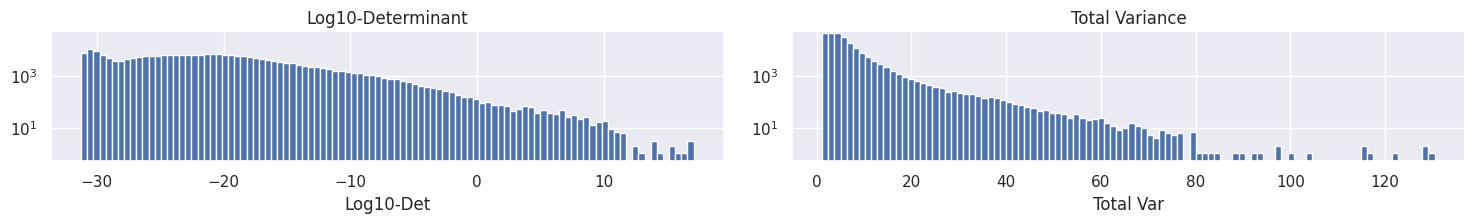

In [ ]:
x_val_log10det = x_val_Sigma.logdet() * np.log10(np.e)
x_val_total_var = torch.diagonal(x_val_Sigma, dim1=-1, dim2=-2).sum(-1)

print(f"Top-5 Mimimum Log10-Det: {np.sort(x_val_log10det)[:5]} (Data index: {np.argsort(x_val_log10det)[:5].tolist()})")
print(f"Top-5 Maximum Log10-Det: {np.sort(x_val_log10det)[-5:]} (Data index: {np.argsort(x_val_log10det)[-5:].tolist()})")
print(f"Top-5 Minimum Total Variance: {np.sort(x_val_total_var)[:5]} (Data index: {np.argsort(x_val_total_var)[:5].tolist()})")
print(f"Top-5 Maximum Total Variance: {np.sort(x_val_total_var)[-5:]} (Data index: {np.argsort(x_val_total_var)[-5:].tolist()})")

fig, ax = plt.subplots(1,2, figsize=(15,2))
fig.tight_layout()
h_logdet = ax[0].hist(x_val_log10det, bins=100, log=True)
ax[0].set_title("Log10-Determinant")
ax[0].set_xlabel("Log10-Det")
h_corr = ax[1].hist(x_val_total_var, bins=100, log=True)
ax[1].set_title("Total Variance")
ax[1].set_xlabel("Total Var")
ax[0].set_ylim(0.5, max(h_logdet[0].max(), h_corr[0].max())*1.1)
ax[1].set_ylim(0.5, max(h_logdet[0].max(), h_corr[0].max())*1.1)
plt.show()


#### Inspect a specific validation data point

In [ ]:
val_data_idx = 222750

print(f"User ID: {user_ids_val[val_data_idx]}")
print("*"*25)
print("{:<20}{:>5}".format("Condition", "Value"))
print("="*25)
for k, v in x_val_conditions.items():
    print(f"{k:<20}" + " ".join([f"{x:.2f}" for x in v[val_data_idx]]))

User ID: 2381
*************************
Condition           Value
months              10.00
weekdays            3.00
users               0.05 0.05 0.05 0.05 0.05 345.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05


In [ ]:
z_rec["params"]["mu"][val_data_idx], z_rec["params"]["sigma"][val_data_idx]

(tensor([ 1.8930e-03, -3.4789e-03, -2.5437e-03, -3.2583e-03, -7.1445e-01,
         -5.5406e-02, -2.5111e-04, -1.8310e-04, -2.0282e-03, -1.8680e-03,
          2.1634e-03,  7.0151e-04, -2.0118e-04,  3.1643e-03,  5.9270e-05,
          1.4134e-01,  1.0907e-03, -2.3836e-04, -4.8773e-03, -1.0722e-03,
         -1.2135e-03,  2.4091e-03, -4.1189e-01,  2.2593e-03]),
 tensor([1.0005, 0.9995, 1.0012, 0.9995, 0.2512, 0.6631, 0.9987, 0.9999, 0.9996,
         0.9988, 0.9976, 0.9991, 0.9996, 1.0011, 1.0002, 0.3525, 0.9998, 0.9993,
         1.0016, 1.0003, 1.0002, 0.9998, 0.4634, 1.0011]))

In [ ]:
print(f"Reconstruction Log-Likelihood: {rll_val[val_data_idx]}")
print("*"*100)
print(f"KL Divergence: {kl_val[val_data_idx]}")
print("*"*100)
print(f"Log10-Determinant: {x_val_log10det[val_data_idx]}")
print("*"*100)
print(f"Eigenvalues: {torch.linalg.eigvalsh(x_val_Sigma[val_data_idx])}")
print("*"*100)
print(f"Total Variance: {x_val_total_var[val_data_idx]}")
print("*"*100)
print(f"Marginal Variances: {x_val_Sigma[val_data_idx].diag().detach()}")
print("*"*100)
print(f"sigma values: {x_rec['params']['sigma'][0,val_data_idx]}")

Reconstruction Log-Likelihood: -1360.869873046875
****************************************************************************************************
KL Divergence: 2.376736640930176
****************************************************************************************************
Log10-Determinant: -29.713655471801758
****************************************************************************************************
Eigenvalues: tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 1.6209])
****************************************************************************************************
Total Variance: 2.770963668823242
****************************************************************************************************
Marginal Variances: tensor([0.1204, 0.1207, 0.1224, 0.1245, 0.1258, 0.1264, 0.1248, 0.1207, 0.1156,
        0

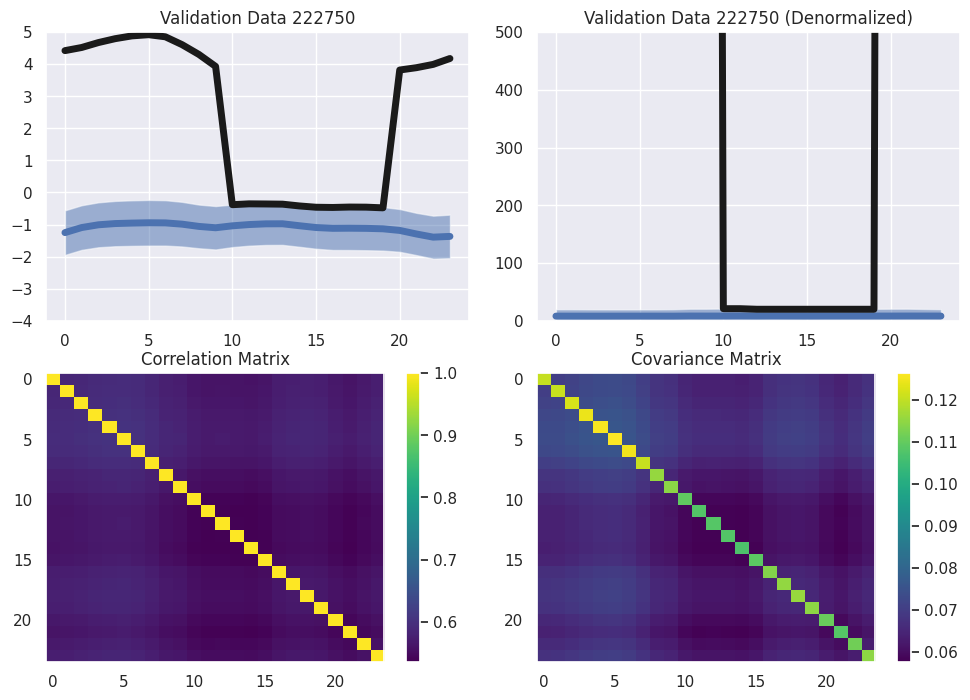

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
fig.tight_layout()
ax[0,0].plot(x_rec_mu[val_data_idx].detach().numpy(), lw=5)
ax[0,0].fill_between(np.arange(x_rec_mu.shape[1]), (x_rec_mu-2*x_rec_sigma)[val_data_idx], (x_rec_mu+2*x_rec_sigma)[val_data_idx], alpha=0.5)
ax[0,0].plot(x_val[val_data_idx].numpy(), lw=5, color='k')
ax[0,0].set_title(f"Validation Data {val_data_idx}")
ax[0,0].set_ylim(-4, 5)

ax[0,1].plot(x_rec_denorm[val_data_idx].T, lw=5)
ax[0,1].fill_between(np.arange(x_rec_denorm.shape[1]), x_rec_denorm_sigma_low[val_data_idx], x_rec_denorm_sigma_high[val_data_idx], alpha=0.5)
ax[0,1].plot(x_val_denorm[val_data_idx].T, lw=5, color='k')
ax[0,1].set_title(f"Validation Data {val_data_idx} (Denormalized)")
ax[0,1].set_ylim(0, max(x_rec_denorm_sigma_high[val_data_idx].max(),500))

im = ax[1,0].imshow(x_val_Corr[val_data_idx], aspect='auto', cmap='viridis', interpolation='nearest')
ax[1,0].set_title(f"Correlation Matrix")
ax[1,0].grid(False)
plt.colorbar(im)

im = ax[1,1].imshow(x_val_Sigma[val_data_idx], aspect='auto', cmap='viridis', interpolation='none')
ax[1,1].set_title(f"Covariance Matrix")
ax[1,1].grid(False)
plt.colorbar(im)
plt.show()

### Validation subset and reconstruction samples

In [ ]:
num_subsamples, num_rec_samples = 5, 2
random_idx = np.random.choice(len(X_val), num_subsamples, replace=False)

In [ ]:
samples = model.decoder.sample({k: v[0,random_idx] for k, v in x_rec["params"].items()},num_samples=num_rec_samples).detach()
samples_denorm = utils.zero_preserved_log_denormalize(samples, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)

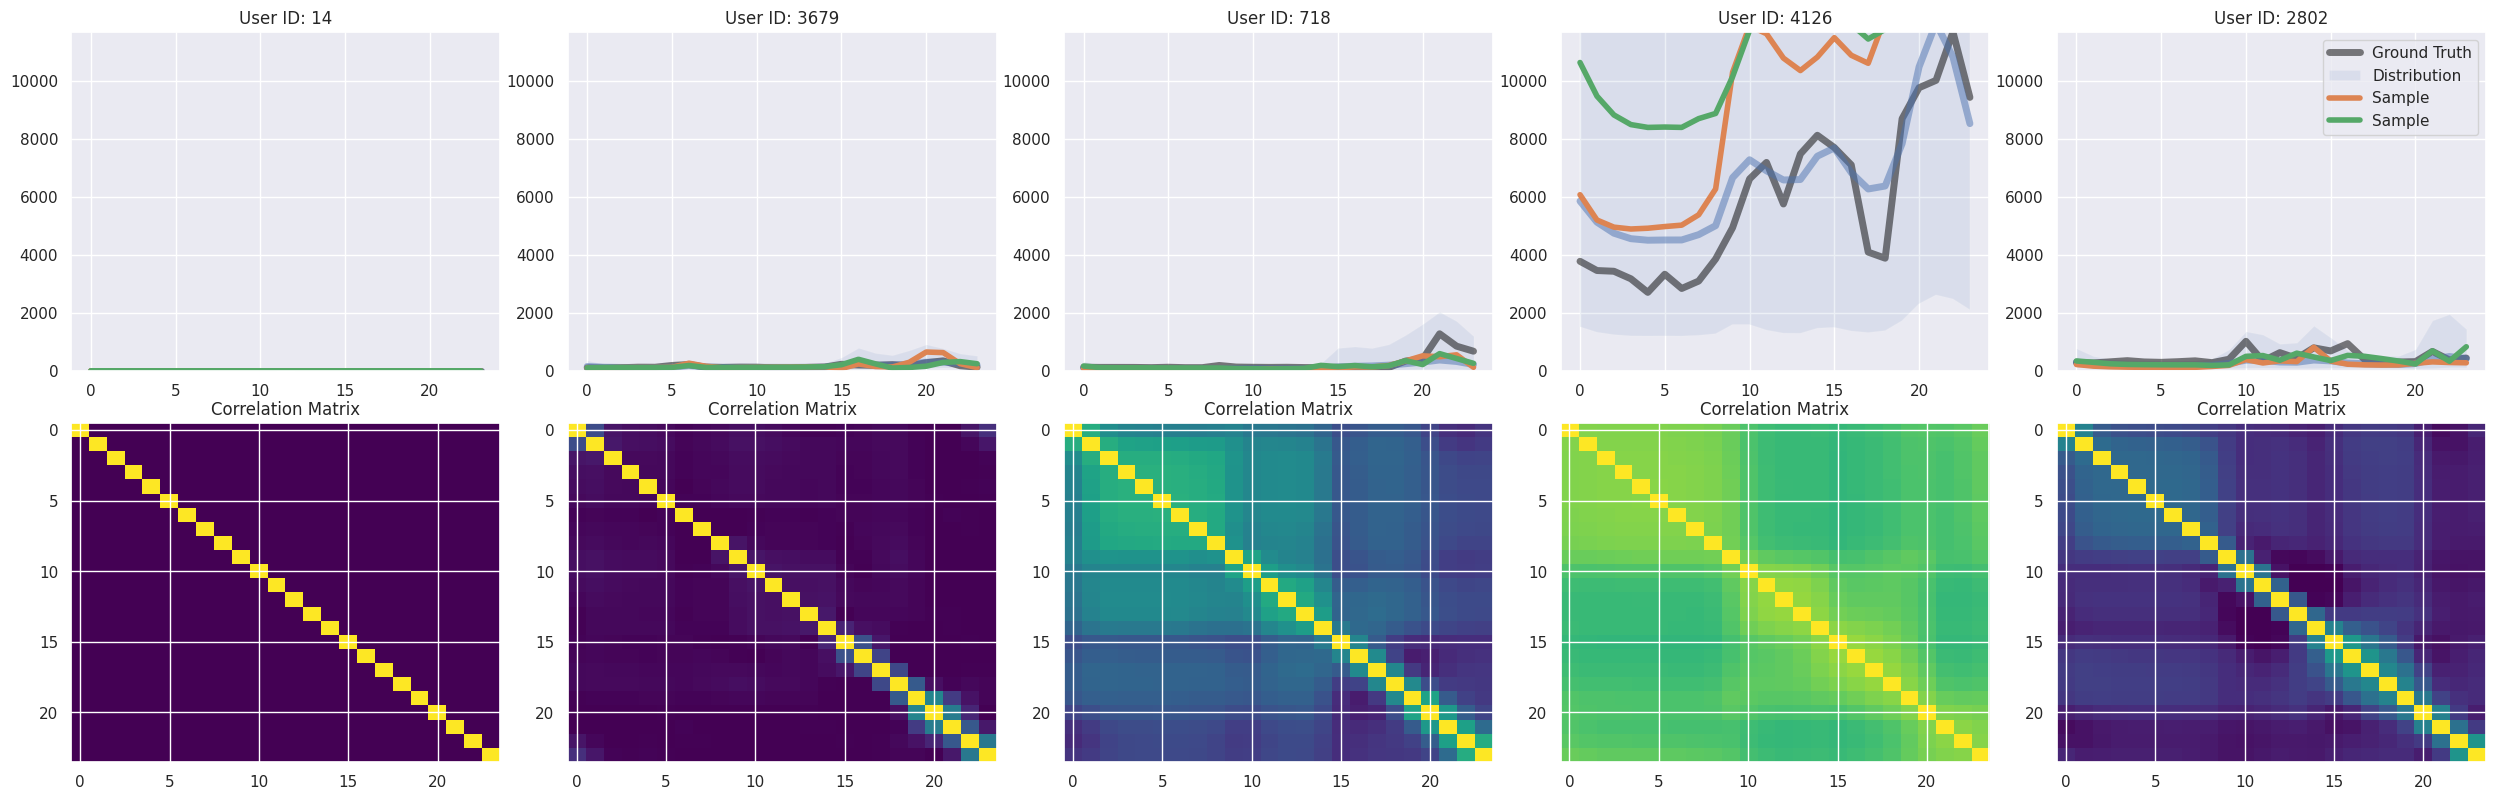

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(25, 8))
fig.tight_layout()
for i in range(5):
    ax[0,i].plot(x_val_denorm[random_idx[i]].T, lw=5, alpha=0.5, color='black', label='Ground Truth')
    ax[0,i].plot(x_rec_denorm[random_idx[i]].T, lw=5, alpha=0.5)
    ax[0,i].fill_between(np.arange(x_val_denorm.shape[1]), x_rec_denorm_sigma_low[random_idx[i]].T, x_rec_denorm_sigma_high[random_idx[i]].T, alpha=0.1, label="Distribution")
    ax[0,i].plot(samples_denorm[:,i,:].squeeze().T, lw=4, label='Sample')
    ax[0,i].set_ylim([0, np.max(x_val_denorm[random_idx]).item()])
    ax[0,i].set_title(f"User ID: {user_ids_val[random_idx[i]]}")

    im = ax[1,i].imshow(x_val_Corr[random_idx[i]], aspect='auto', cmap='viridis', interpolation='none', vmin=0, vmax=1)
    ax[1,i].set_title(f"Correlation Matrix")
ax[0,-1].legend()
plt.show()

### Random sample

In [ ]:
random_condition_set, random_conditions = conditioner.get_random_conditions(1)
random_user_idx = np.random.choice(user_gamma.shape[0])
random_conditions["users"] = user_gamma[[random_user_idx]]
random_condition_set =  conditioner.transform(random_conditions)

print(f"User ID: {random_user_idx}")
print(f"*"*25)
print("{:<20}{:>5}".format("Condition", "Value"))
print("="*25)
for k, v in random_conditions.items():
    print(f"{k:<20}" + " ".join([f"{x:.2f}" for x in v[0]]))

User ID: 5958
*************************
Condition           Value
months              4.00
weekdays            6.00
users               2.03 0.05 0.05 0.05 1.68 0.05 0.05 0.05 50.53 0.05 0.05 1.96 0.05 0.05 2.38 53.34 106.13 0.05 143.36 0.05


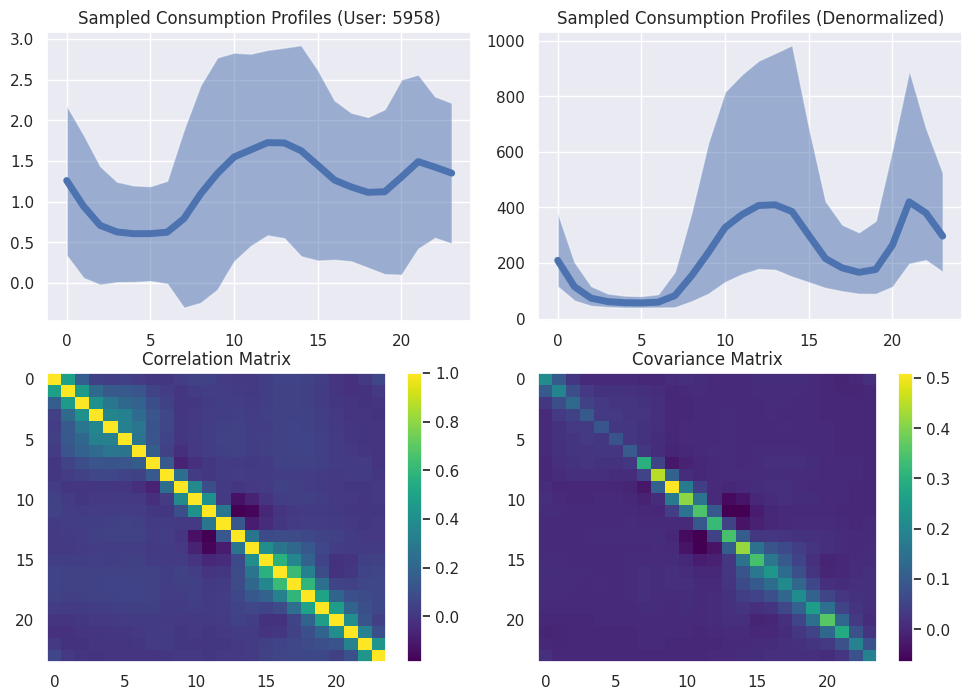

In [ ]:
x_sample = model.sample(condition=torch.tensor(random_condition_set).float(), num_samples_prior=1, num_samples_likelihood=1)
x_mu = x_sample["params"]["mu"].detach()
x_sigma = model.decoder.get_marginal_sigmas(x_sample["params"]).detach()
x_mu_denorm = utils.zero_preserved_log_denormalize(x_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_sigma_upper_denorm = utils.zero_preserved_log_denormalize(x_mu+x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_sigma_lower_denorm = utils.zero_preserved_log_denormalize(x_mu-x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_Sigma = model.decoder.create_covariance_matrix(x_sample["params"]).detach()
x_Corr = x_Sigma/ (x_sigma[...,None]*x_sigma[:,None,:])

fig, ax = plt.subplots(2, 2, figsize=(10, 7))
fig.tight_layout()
ax[0,0].plot(x_mu.T, lw=5)
ax[0,0].fill_between(np.arange(x_mu.shape[1]), (x_mu-2*x_sigma)[0], (x_mu+2*x_sigma)[0], alpha=0.5)
ax[0,0].set_title(f"Sampled Consumption Profiles (User: {random_user_idx})")
ax[0,1].plot(x_mu_denorm.T, lw=5)
ax[0,1].fill_between(np.arange(x_mu_denorm.shape[1]), x_sigma_lower_denorm[0], x_sigma_upper_denorm[0], alpha=0.5)
ax[0,1].set_title("Sampled Consumption Profiles (Denormalized)")
im = ax[1,0].imshow(x_Corr[0], aspect='auto', cmap='viridis', interpolation='nearest')
ax[1,0].set_title(f"Correlation Matrix")
ax[1,0].grid(False)
plt.colorbar(im)
im = ax[1,1].imshow(x_Sigma[0], aspect='auto', cmap='viridis', interpolation='none')
ax[1,1].set_title(f"Covariance Matrix")
ax[1,1].grid(False)
plt.colorbar(im)
plt.show()

## Inspection for a specific user

### Reconstruction samples

In [ ]:
user_id_selected = 0
random_idx = np.random.choice(np.where(user_ids_val == user_id_selected)[0], num_subsamples, replace=False)

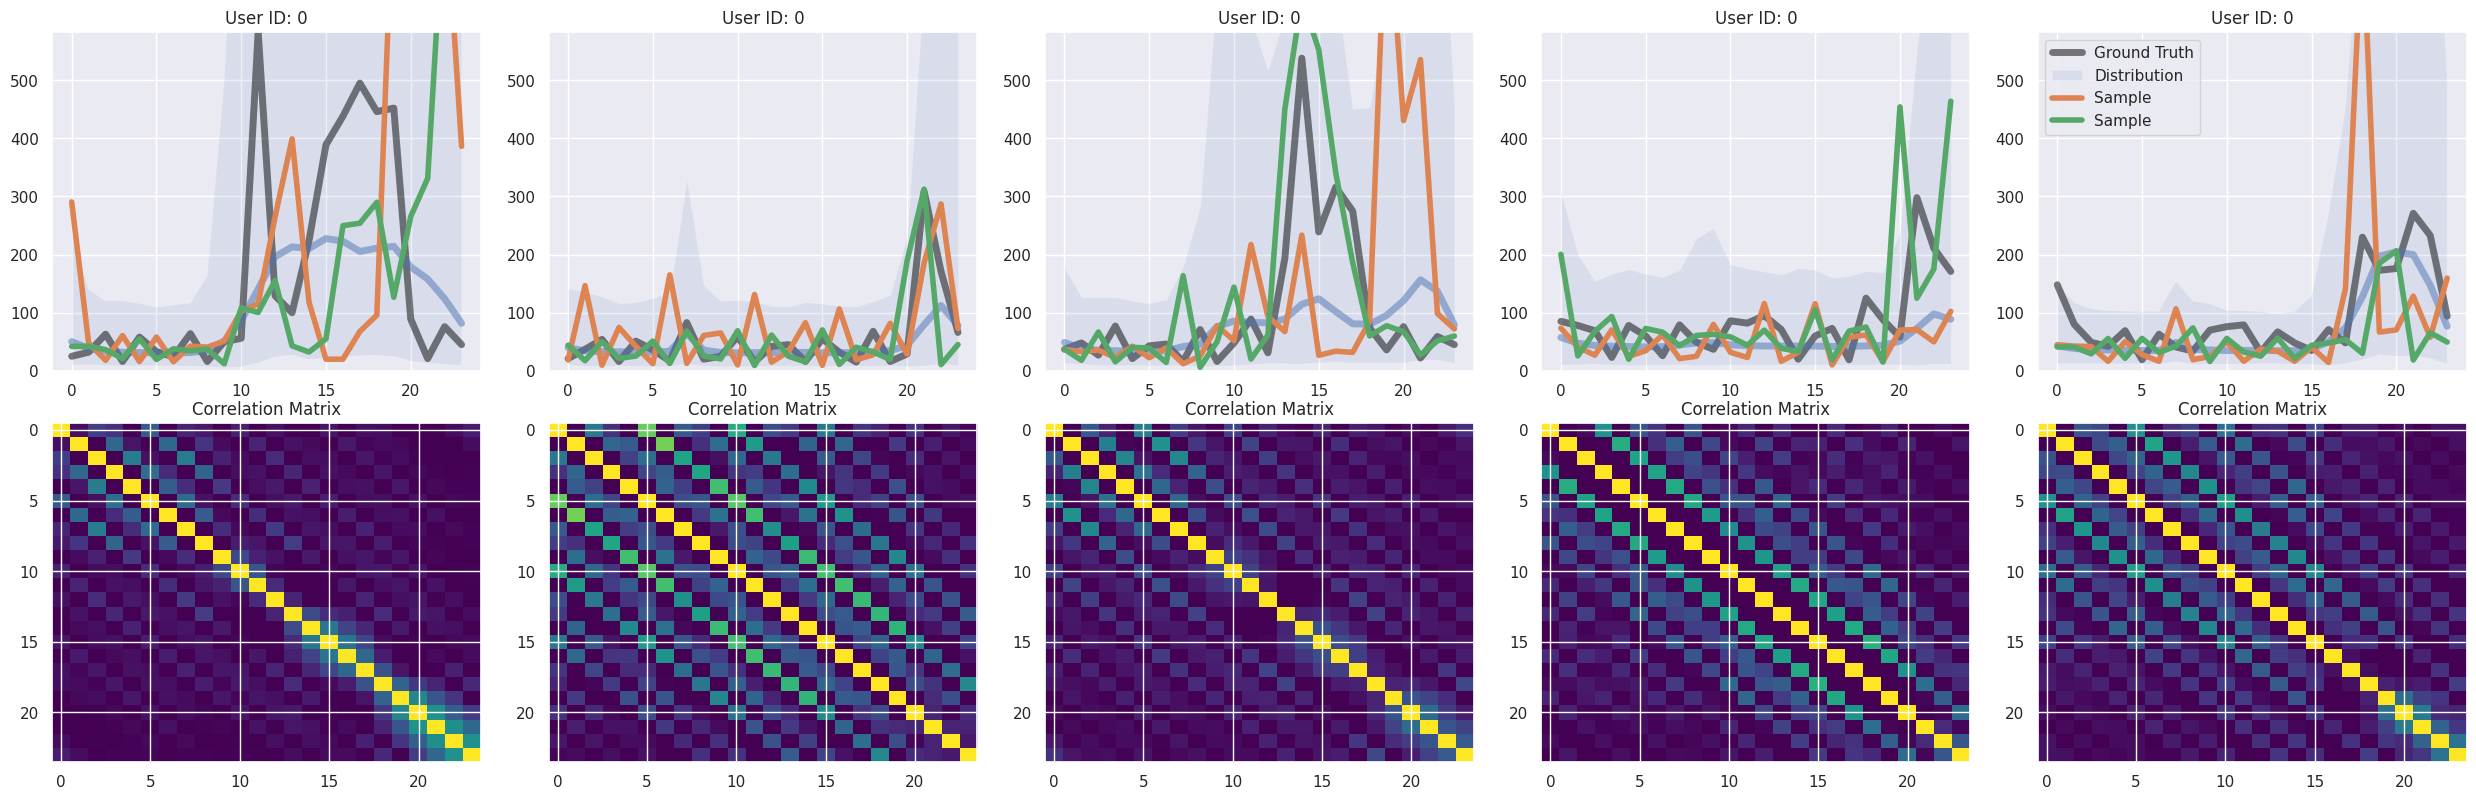

In [ ]:
samples = model.decoder.sample({k: v[0,random_idx] for k, v in x_rec["params"].items()},num_samples=num_rec_samples).detach()
samples_denorm = utils.zero_preserved_log_denormalize(samples, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)

fig, ax = plt.subplots(2, 5, figsize=(25, 8))
fig.tight_layout()
for i in range(5):
    ax[0,i].plot(x_val_denorm[random_idx[i]].T, lw=5, alpha=0.5, color='black', label='Ground Truth')
    ax[0,i].plot(x_rec_denorm[random_idx[i]].T, lw=5, alpha=0.5)
    ax[0,i].fill_between(np.arange(x_val_denorm.shape[1]), x_rec_denorm_sigma_low[random_idx[i]].T, x_rec_denorm_sigma_high[random_idx[i]].T, alpha=0.1, label="Distribution")
    ax[0,i].plot(samples_denorm[:,i,:].squeeze().T, lw=4, label='Sample')
    ax[0,i].set_ylim([0, np.max(x_val_denorm[random_idx]).item()])
    ax[0,i].set_title(f"User ID: {user_ids_val[random_idx[i]]}")

    im = ax[1,i].imshow(x_val_Corr[random_idx[i]], aspect='auto', cmap='viridis', interpolation='none', vmin=0, vmax=1)
    ax[1,i].set_title(f"Correlation Matrix")
ax[0,-1].legend()
plt.show()

### Random sample

In [ ]:
random_condition_set, random_conditions = conditioner.get_random_conditions(1)
random_conditions["users"] = user_gamma[[user_id_selected]]
random_condition_set =  conditioner.transform(random_conditions)

print(f"User ID: {random_user_idx}")
print(f"*"*25)
print("{:<20}{:>5}".format("Condition", "Value"))
print("="*25)
for k, v in random_conditions.items():
    print(f"{k:<20}" + " ".join([f"{x:.2f}" for x in v[0]]))

User ID: 5958
*************************
Condition           Value
months              7.00
weekdays            5.00
users               8.07 0.05 0.05 0.05 0.05 0.05 0.05 0.05 3.85 0.05 0.05 304.26 0.05 0.05 47.01 0.05 0.05 0.05 0.05 0.05


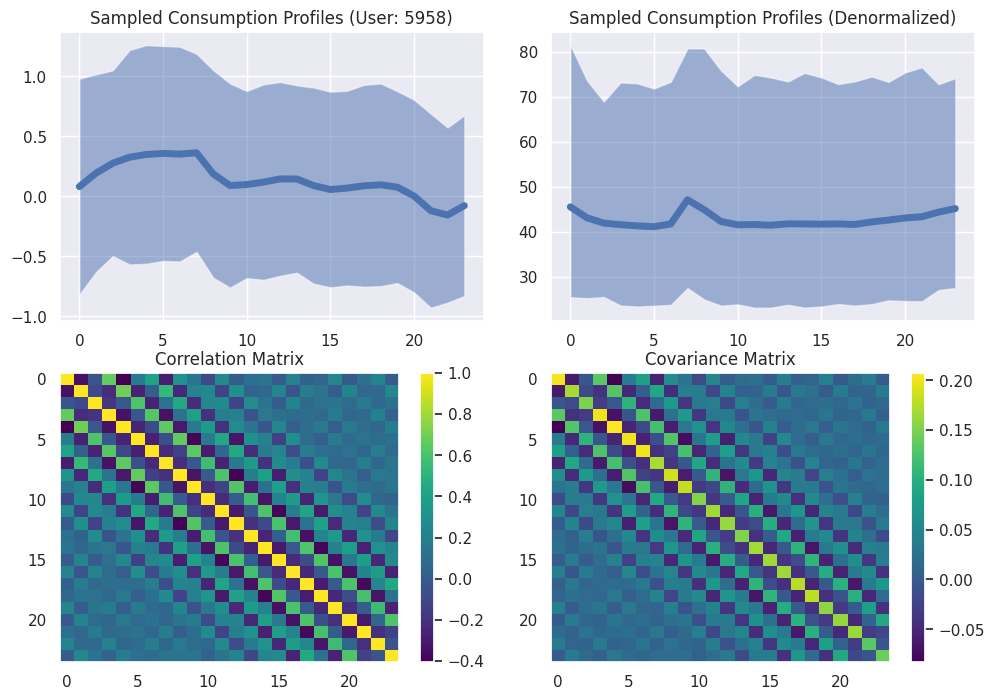

In [ ]:
x_sample = model.sample(condition=torch.tensor(random_condition_set).float(), num_samples_prior=1, num_samples_likelihood=1)
x_mu = x_sample["params"]["mu"].detach()
x_sigma = model.decoder.get_marginal_sigmas(x_sample["params"]).detach()
x_mu_denorm = utils.zero_preserved_log_denormalize(x_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_sigma_upper_denorm = utils.zero_preserved_log_denormalize(x_mu+x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_sigma_lower_denorm = utils.zero_preserved_log_denormalize(x_mu-x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_Sigma = model.decoder.create_covariance_matrix(x_sample["params"]).detach()
x_Corr = x_Sigma/ (x_sigma[...,None]*x_sigma[:,None,:])

fig, ax = plt.subplots(2, 2, figsize=(10, 7))
fig.tight_layout()
ax[0,0].plot(x_mu.T, lw=5)
ax[0,0].fill_between(np.arange(x_mu.shape[1]), (x_mu-2*x_sigma)[0], (x_mu+2*x_sigma)[0], alpha=0.5)
ax[0,0].set_title(f"Sampled Consumption Profiles (User: {random_user_idx})")
ax[0,1].plot(x_mu_denorm.T, lw=5)
ax[0,1].fill_between(np.arange(x_mu_denorm.shape[1]), x_sigma_lower_denorm[0], x_sigma_upper_denorm[0], alpha=0.5)
ax[0,1].set_title("Sampled Consumption Profiles (Denormalized)")
im = ax[1,0].imshow(x_Corr[0], aspect='auto', cmap='viridis', interpolation='nearest')
ax[1,0].set_title(f"Correlation Matrix")
ax[1,0].grid(False)
plt.colorbar(im)
im = ax[1,1].imshow(x_Sigma[0], aspect='auto', cmap='viridis', interpolation='none')
ax[1,1].set_title(f"Covariance Matrix")
ax[1,1].grid(False)
plt.colorbar(im)
plt.show()

## Backcasting

In [ ]:
test_data = utils.zero_preserved_log_normalize(X_gt_list[0]*1.0, nonzero_mean, nonzero_std, log_output=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)

In [ ]:
params, samples = model.sample(condition=torch.tensor(conditioner.transform({k: v[0] for k,v in X_gt_condition_list.items()})).float())

In [ ]:
model.loglikelihood(torch.tensor(test_data).float(), torch.tensor(conditioner.transform({k: v[0] for k,v in X_gt_condition_list.items()})).float(), num_mc_samples=100).detach().numpy()

array([-0.66815835, -2.0617533 ], dtype=float32)

In [ ]:
backcasting_loglikelihoods = []
for user_id in range(num_users):
    test_data = utils.zero_preserved_log_normalize(X_gt_list[user_id]*1.0, nonzero_mean, nonzero_std, log_output=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
    if test_data.shape[0] == 0: loglikelihood = np.array([])
    else:
        loglikelihood = model.loglikelihood(torch.tensor(test_data).float(), torch.tensor(conditioner.transform({k: v[user_id] for k,v in X_gt_condition_list.items()})).float(), num_mc_samples=100).detach().numpy()
    backcasting_loglikelihoods.append(loglikelihood)
    print(f"User ID: {user_id}, Log-Likelihood: {loglikelihood.sum()}")

User ID: 0, Log-Likelihood: -2.020219087600708
User ID: 1, Log-Likelihood: 0.0
User ID: 2, Log-Likelihood: -67.46055603027344
User ID: 3, Log-Likelihood: -14.088981628417969
User ID: 4, Log-Likelihood: -139.0316925048828
User ID: 5, Log-Likelihood: -224.05935668945312
User ID: 6, Log-Likelihood: 1095.804931640625
User ID: 7, Log-Likelihood: 19.468660354614258
User ID: 8, Log-Likelihood: 84.17765808105469
User ID: 9, Log-Likelihood: 147.8486328125
User ID: 10, Log-Likelihood: -2.1551599502563477
User ID: 11, Log-Likelihood: -81.90727233886719
User ID: 12, Log-Likelihood: 36.58930206298828
User ID: 13, Log-Likelihood: -1.6023731231689453
User ID: 14, Log-Likelihood: 14.193429946899414
User ID: 15, Log-Likelihood: -224.81126403808594
User ID: 16, Log-Likelihood: -15.529329299926758
User ID: 17, Log-Likelihood: -154.5851593017578
User ID: 18, Log-Likelihood: -47.99974822998047
User ID: 19, Log-Likelihood: 107.25044250488281
User ID: 20, Log-Likelihood: 0.0
User ID: 21, Log-Likelihood: 135.

KeyboardInterrupt: 

In [ ]:
X_gt_condition_list["users"][3]

array([[1.40109458e+02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
        5.00000000e-02, 5.00000000e-02, 5.00000001e-02, 1.84115748e+00,
        6.68443832e+00, 1.86849180e+01, 5.00000000e-02, 1.67537314e+02,
        5.00000000e-02, 5.00000001e-02, 2.54427149e+01, 5.00000024e-02,
        5.00000001e-02, 5.00000021e-02, 5.00000010e-02, 5.00000000e-02],
       [1.40109458e+02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
        5.00000000e-02, 5.00000000e-02, 5.00000001e-02, 1.84115748e+00,
        6.68443832e+00, 1.86849180e+01, 5.00000000e-02, 1.67537314e+02,
        5.00000000e-02, 5.00000001e-02, 2.54427149e+01, 5.00000024e-02,
        5.00000001e-02, 5.00000021e-02, 5.00000010e-02, 5.00000000e-02],
       [1.40109458e+02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
        5.00000000e-02, 5.00000000e-02, 5.00000001e-02, 1.84115748e+00,
        6.68443832e+00, 1.86849180e+01, 5.00000000e-02, 1.67537314e+02,
        5.00000000e-02, 5.00000001e-02, 2.54427149e+01, 5.0000

In [ ]:
{k: v[user_id] for k,v in X_gt_condition_list.items()}

{'months': array([[6],
        [6]]),
 'weekdays': array([[1],
        [2]]),
 'users': array([[2.56762031e+02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
         5.00000011e-02, 5.00000000e-02, 5.00000010e-02, 2.67063027e+01,
         5.00000013e-02, 5.42090832e+00, 5.00000000e-02, 9.59837241e+00,
         5.00000000e-02, 5.40402870e+00, 5.00000001e-02, 5.00000002e-02,
         5.60785345e+00, 5.00000000e-02, 5.38505034e+01, 5.00000000e-02],
        [2.56762031e+02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
         5.00000011e-02, 5.00000000e-02, 5.00000010e-02, 2.67063027e+01,
         5.00000013e-02, 5.42090832e+00, 5.00000000e-02, 9.59837241e+00,
         5.00000000e-02, 5.40402870e+00, 5.00000001e-02, 5.00000002e-02,
         5.60785345e+00, 5.00000000e-02, 5.38505034e+01, 5.00000000e-02]])}